In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
sns.set(context='poster', style='white', font='CMU Serif',
    rc={'font.size':10, 'mathtext.fontset': 'cm', 'axes.labelpad':0, 'axes.linewidth': 0.5})

std: 0.06021234690106539


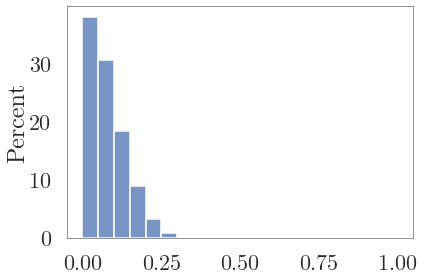

In [11]:
def measure_ssp_components(dim, turn_exp=1, coin_exp=1):
    sampler = nengo.dists.UniformHypersphere()
    def make_unitary(v):
        return v/np.absolute(v)
    turn_basis = make_unitary(np.fft.fft(sampler.sample(1, dim)))
    coin_basis = make_unitary(np.fft.fft(sampler.sample(1, dim)))
    def encode_state(t, c):
        return np.fft.ifft(turn_basis**(t*turn_exp) * coin_basis**(c*coin_exp)).real.squeeze()
    components = []
    for t in range(6):
        for c in range(31):
            components.append(encode_state(t, c))
    components = np.ravel(np.abs(components))
    fig, ax = plt.subplots()
    sns.histplot(components, bins=20, stat="percent", ax=ax);
    plt.tight_layout()
    print(f"std: {np.std(components)}")

measure_ssp_components(100)

In [103]:
def GatedDiffMemoryDynamics(seeds=1, dim=100, turn_exp=1, coin_exp=1,
                            n_array=500, n_neurons=5000, gain=0.1, radius=0.3):

    def make_unitary(v):
        return v/np.absolute(v)

    def measure_similarity(ssp1, ssp2, mode="dot"):
        if mode=="dot":
            return np.sum(ssp1 * ssp2)
        elif mode=="cosine":
            return np.sum(ssp1 * ssp2) / (np.linalg.norm(ssp1, ord=2) * np.linalg.norm(ssp2, ord=2))
    
    def measure_magnitude(ssp):
        return np.linalg.norm(ssp, ord=2)

    def encode_state(t, c, turn_basis, coin_basis, turn_exp=1, coin_exp=1):
        return np.fft.ifft(turn_basis**(t*turn_exp) * coin_basis**(c*coin_exp)).real.squeeze()

    class SSPInpt():
        def __init__(self, dim):
            self.state = np.zeros((dim))
        def set_state(self, state):
            self.state = state
        def get_state(self):
            return self.state

    def StateGateMemory(n_array, dim, seed, gain, radius, synapse=0):
        wInh = -1e1*np.ones((n_array*dim, 1))
        net = nengo.Network(seed=seed)
        with net:
            net.state = nengo.Node(size_in=dim)
            net.output = nengo.Node(size_in=dim)
            net.gate = nengo.Node(size_in=1)
            net.mem = nengo.networks.EnsembleArray(n_array, dim, radius=radius)
            net.diff = nengo.networks.EnsembleArray(n_array, dim, radius=radius)
            net.diff.add_neuron_input()
            nengo.Connection(net.state, net.diff.input, synapse=None)
            nengo.Connection(net.diff.output, net.mem.input, transform=gain, synapse=synapse)
            nengo.Connection(net.mem.output, net.mem.input, synapse=synapse)
            nengo.Connection(net.mem.output, net.diff.input, transform=-1, synapse=synapse)
            nengo.Connection(net.gate, net.diff.neuron_input, transform=wInh, synapse=None)
            nengo.Connection(net.mem.output, net.output, synapse=None)
        return net

    dfs = []
    columns = ('seed', 'trial', 't', 'diff mag', 'mem mag', 'diff sim', 'mem sim')
    for seed in range(seeds):
        
        sampler = nengo.dists.UniformHypersphere()
        turn_basis = make_unitary(np.fft.fft(sampler.sample(1, dim)))
        coin_basis = make_unitary(np.fft.fft(sampler.sample(1, dim)))
        ssp_inpt = SSPInpt(dim)
        network = nengo.Network(seed=seed)
        network.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        network.config[nengo.Ensemble].max_rates = nengo.dists.Uniform(400, 400)
        network.config[nengo.Probe].synapse = None
        with network:
        
            state_input = nengo.Node(lambda t, x: ssp_inpt.get_state(), size_in=2, size_out=dim)
            buffer_input = nengo.Node(1)
            state_memory = StateGateMemory(n_array, dim, seed, gain, radius)
            nengo.Connection(state_input, state_memory.state, synapse=None)
            nengo.Connection(buffer_input, state_memory.gate, function=lambda x: 1-x, synapse=None)
            p_state_input = nengo.Probe(state_input)
            p_diff = nengo.Probe(state_memory.diff.output)
            p_mem = nengo.Probe(state_memory.mem.output)

        sim = nengo.Simulator(network, progress_bar=False)
        
        trial = 0
        for turn in range(6):
            coin = 10
#             for coin in range(3):
            trial += 1
            sim.reset(seed)
            ssp = encode_state(turn, coin, turn_basis, coin_basis)
            ssp_inpt.set_state(ssp)
            sim.run(0.1, progress_bar=False)

            inpts = sim.data[p_state_input]
            diffs = sim.data[p_diff]
            mems = sim.data[p_mem]
            for t in range(len(sim.trange())):
                dfs.append(pd.DataFrame([[
                    seed,
                    trial,
                    t*0.001,
                    measure_magnitude(diffs[t]),
                    measure_magnitude(mems[t]),
                    measure_similarity(inpts[t], diffs[t]),
                    measure_similarity(inpts[t], mems[t])]],
                    columns=columns))

    data = pd.concat(dfs, ignore_index=True)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((8,8)))
    sns.lineplot(data=data, x='t', y='diff sim', ax=axes[0][0])
    sns.lineplot(data=data, x='t', y='mem sim', ax=axes[0][1])
    sns.lineplot(data=data, x='t', y='diff mag', ax=axes[1][0])
    sns.lineplot(data=data, x='t', y='mem mag', ax=axes[1][1])
#     sns.lineplot(data=data, x='t', y='diff sim', units='trial', estimator=None, hue='seed', ax=axes[0][0])
#     sns.lineplot(data=data, x='t', y='mem sim', units='trial', estimator=None, hue='seed', ax=axes[0][1])
#     sns.lineplot(data=data, x='t', y='diff mag', units='trial', estimator=None, hue='seed', ax=axes[1][0])
#     sns.lineplot(data=data, x='t', y='mem mag', units='trial', estimator=None, hue='seed', ax=axes[1][1])
    plt.tight_layout()

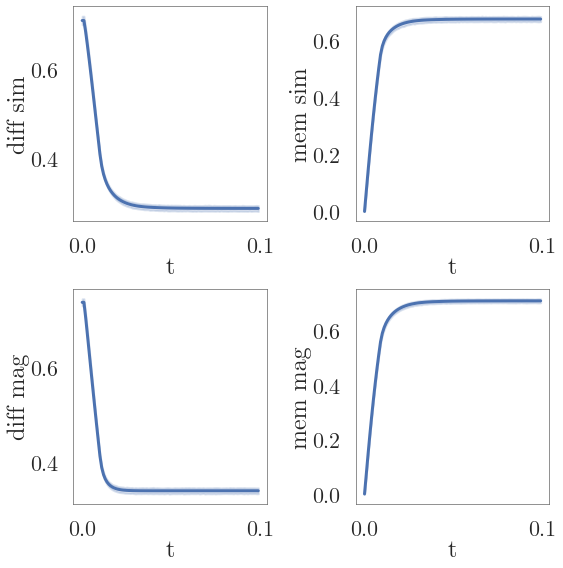

In [104]:
GatedDiffMemoryDynamics(seeds=3, gain=0.1, radius=0.1)

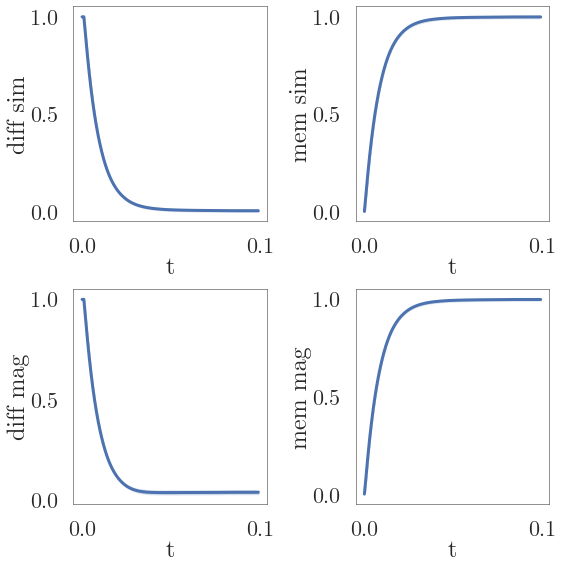

In [105]:
GatedDiffMemoryDynamics(seeds=3, gain=0.1, radius=0.3)

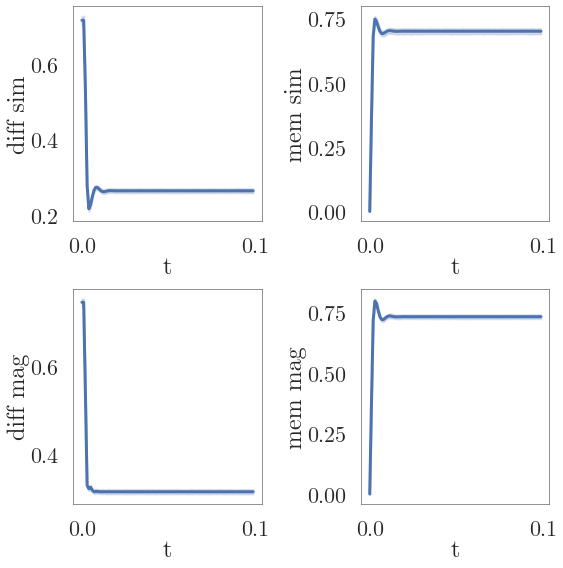

In [106]:
GatedDiffMemoryDynamics(seeds=3, gain=0.5, radius=0.1)

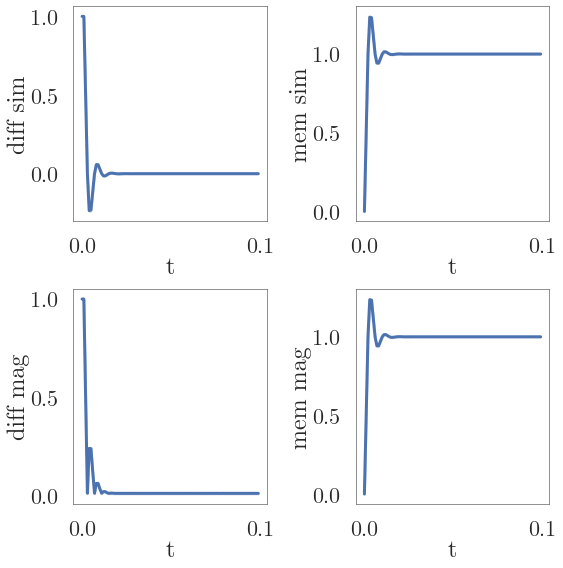

In [107]:
GatedDiffMemoryDynamics(seeds=3, gain=0.5, radius=0.3)

In [3]:
class NQ():

    class Environment():
        def __init__(self, ssp_dim, t1, t2, t3, rng, dt=1e-3):
            self.state = np.zeros((ssp_dim))
            self.rng = rng
            self.t1 = t1
            self.t2 = t2
            self.t3 = t3
            self.dt = dt
            self.replay = 0
            self.buffer = 0
        def set_state(self, state):
            self.state = state
        def get_state(self):
            return self.state
        def get_replay(self):
            return self.replay
        def get_buffer(self):
            return self.buffer
        
    def __init__(self, player, seed=0,
            learning_rate=1e-7, n_neurons=10000, n_array=1000,
            ssp_dim=100, sparsity=0.05, turn_exp=1.0, coin_exp=1.0,
            gate_mode="direct", memory_mode="direct", cleanup_mode=None,
            dt=1e-3, t1=1e-1, t2=1e-1, t3=1e-1, tR=1e-2):
        self.player = player
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        self.n_neurons = n_neurons
        self.n_array = n_array
        self.dt = dt
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        self.tR = tR
        self.ssp_dim = ssp_dim
        self.sparsity = sparsity
        self.memory_mode = memory_mode
        self.gate_mode = gate_mode
        self.cleanup_mode = cleanup_mode
        self.turn_exp = turn_exp
        self.coin_exp = coin_exp
        sampler = nengo.dists.UniformHypersphere()
        self.turn_basis = self.make_unitary(np.fft.fft(sampler.sample(1, ssp_dim, rng=self.rng)))
        self.coin_basis = self.make_unitary(np.fft.fft(sampler.sample(1, ssp_dim, rng=self.rng)))
        self.intercept = nengo.dists.Choice([self.sparsity_to_x_intercept(ssp_dim, sparsity)])
        self.env = self.Environment(self.ssp_dim, t1, t2, t3, self.rng)
        self.encoders = self.make_encoders()
        self.network = self.build_network()
        self.simulator = nengo.Simulator(self.network, progress_bar=False)
        self.sM = np.zeros((ssp_dim))
        self.spikesM = np.zeros((n_neurons))
        self.simMRs = []
        self.sim01s = []
        self.mag0s  = []
        self.mag1s  = []
        self.uni01s = []
        self.qui01s = []
        self.uniMRs = []
        self.quiMRs = []

    def make_unitary(self, v):
        return v/np.absolute(v)

    def encode_state(self, t, c):
        return np.fft.ifft(self.turn_basis**(t*self.turn_exp) * self.coin_basis**(c*self.coin_exp)).real.squeeze()
    
    def sparsity_to_x_intercept(self, d, p):
        sign = 1
        if p > 0.5:
            p = 1.0 - p
            sign = -1
        return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))
    
    def make_encoders(self, n_samples=100):
        encoders = []
        if self.cleanup_mode==None:
            pass
        if self.cleanup_mode=="inputs":
            for t in range(6):
                if self.player == "investor":
                    encoders.append(self.encode_state(t, 10))
                if self.player == "trustee":
                    for c in [3,30]:
                        encoders.append(self.encode_state(t, c))
        if self.cleanup_mode=="uniform":
            for n in range(n_samples):
                t = self.rng.randint(0, 6)
                c = self.rng.randint(0, 31)
                encoders.append(self.encode_state(t, c))
        if self.cleanup_mode=="ordered":
            for t in range(6):
                for c in range(31):
                    encoders.append(self.encode_state(t, c))
        encoders = np.array(encoders)
        return encoders

    def measure_sparsity(self, spikes1, spikes2):
        n_neurons = spikes1.shape[0]
        diff = []
        quiet = 0
        for n in range(n_neurons):
            if spikes1[n]+spikes2[n]>0:
                diff.append((spikes1[n]-spikes2[n]) / (spikes1[n]+spikes2[n]))
            else:
                quiet += 1
        diff = np.array(diff)
        quiet = quiet / n_neurons
        return diff, quiet

    def measure_similarity(self, ssp1, ssp2, mode="dot"):
        if mode=="dot":
            return np.sum(ssp1 * ssp2)
        elif mode=="cosine":
            return np.sum(ssp1 * ssp2) / (np.linalg.norm(ssp1, ord=2) * np.linalg.norm(ssp2, ord=2))

    def build_network(self):
        ssp_dim = self.ssp_dim
        n_neurons = self.n_neurons
        n_array = self.n_array
        seed = self.seed
        network = nengo.Network(seed=seed)
        network.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        network.config[nengo.Ensemble].max_rates = nengo.dists.Uniform(400, 400)
        network.config[nengo.Probe].synapse = None
        with network:

            def StateGate(n_neurons, n_array, dim, seed, mode="array"):
                net = nengo.Network(seed=seed)
                with net:
                    net.a = nengo.Node(size_in=dim)
                    net.b = nengo.Node(size_in=dim)
                    net.output = nengo.Node(size_in=dim)
                    if mode=="neuron":
                        wInh = -1e1*np.ones((n_neurons, 1))
                        net.gate_a = nengo.Ensemble(n_array, 1)
                        net.gate_b = nengo.Ensemble(n_array, 1)
                        net.ens_a = nengo.Ensemble(n_neurons, dim)
                        net.ens_b = nengo.Ensemble(n_neurons, dim)
                        nengo.Connection(net.a, net.ens_a, synapse=None)
                        nengo.Connection(net.b, net.ens_b, synapse=None)
                        nengo.Connection(net.ens_a, net.output, synapse=None)
                        nengo.Connection(net.ens_b, net.output, synapse=None)
                        nengo.Connection(net.gate_a, net.ens_a.neurons, transform=wInh, synapse=None)
                        nengo.Connection(net.gate_b, net.ens_b.neurons, transform=wInh, synapse=None)
                    elif mode=="array":
                        wInh = -1e1*np.ones((n_array*dim, 1))
                        net.gate_a = nengo.Ensemble(n_array, 1)
                        net.gate_b = nengo.Ensemble(n_array, 1)
                        net.ens_a = nengo.networks.EnsembleArray(n_array, dim, radius=np.sqrt(1/dim))
                        net.ens_b = nengo.networks.EnsembleArray(n_array, dim, radius=np.sqrt(1/dim))
                        net.ens_a.add_neuron_input()
                        net.ens_b.add_neuron_input()
                        nengo.Connection(net.a, net.ens_a.input, synapse=None)
                        nengo.Connection(net.b, net.ens_b.input, synapse=None)
                        nengo.Connection(net.ens_a.output, net.output, synapse=None)
                        nengo.Connection(net.ens_b.output, net.output, synapse=None)
                        nengo.Connection(net.gate_a, net.ens_a.neuron_input, transform=wInh, synapse=None)
                        nengo.Connection(net.gate_b, net.ens_b.neuron_input, transform=wInh, synapse=None)
                    elif mode=="direct":
                        net.gate_a = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
                        net.gate_b = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
                        net.ens_a = nengo.Ensemble(1, dim+1, neuron_type=nengo.Direct())
                        net.ens_b = nengo.Ensemble(1, dim+1, neuron_type=nengo.Direct())
                        nengo.Connection(net.a, net.ens_a[:-1], synapse=None)
                        nengo.Connection(net.b, net.ens_b[:-1], synapse=None)
                        nengo.Connection(net.gate_a, net.ens_a[-1], function=lambda x: 1-x, synapse=None)
                        nengo.Connection(net.gate_b, net.ens_b[-1], function=lambda x: 1-x, synapse=None)
                        nengo.Connection(net.ens_a, net.output, function=lambda x: x[:-1]*x[-1], synapse=None)
                        nengo.Connection(net.ens_b, net.output, function=lambda x: x[:-1]*x[-1], synapse=None)
                return net

            class GatedNode(nengo.Node):
                def __init__(self, ssp_dim):
                    self.ssp_dim = ssp_dim
                    self.size_in = ssp_dim + 1
                    self.size_out = ssp_dim
                    self.memory = np.zeros((ssp_dim))
                    super().__init__(self.step, size_in=self.size_in, size_out=self.size_out)
                def step(self, t, x):
                    ssp = x[:-1]
                    gate = int(x[-1])
                    if gate==1:
                        self.memory = ssp
                    return self.memory

            def StateGateMemory(n_neurons, n_array, dim, seed, n_gates=1, gain=0.1, synapse=0, mode="array"):
                net = nengo.Network(seed=seed)
                with net:
                    net.state = nengo.Node(size_in=dim)
                    net.output = nengo.Node(size_in=dim)
                    if mode=="neuron":
                        wInh = -1e1*np.ones((n_neurons, 1))
                        net.gate = nengo.Node(size_in=1)
                        net.mem = nengo.Ensemble(n_neurons, dim)
                        net.diff = nengo.Ensemble(n_neurons, dim)
                        nengo.Connection(net.state, net.diff, synapse=None)
                        nengo.Connection(net.diff, net.mem, transform=gain, synapse=synapse)
                        nengo.Connection(net.mem, net.mem, synapse=synapse)
                        nengo.Connection(net.mem, net.diff, transform=-1, synapse=synapse)
                        nengo.Connection(net.gate, net.diff.neurons, transform=wInh, synapse=None)
                        nengo.Connection(net.mem, net.output, synapse=None)
                    elif mode=="array":
                        wInh = -1e1*np.ones((n_array*dim, 1))
                        net.gate = nengo.Node(size_in=1)
                        net.mem = nengo.networks.EnsembleArray(n_array, dim)
                        net.diff = nengo.networks.EnsembleArray(n_array, dim)
                        net.diff.add_neuron_input()
                        nengo.Connection(net.state, net.diff.input, synapse=None)
                        nengo.Connection(net.diff.output, net.mem.input, transform=gain, synapse=synapse)
                        nengo.Connection(net.mem.output, net.mem.input, synapse=synapse)
                        nengo.Connection(net.mem.output, net.diff.input, transform=-1, synapse=synapse)
                        nengo.Connection(net.gate, net.diff.neuron_input, transform=wInh, synapse=None)
                        nengo.Connection(net.mem.output, net.output, synapse=None)
                    elif mode=="array-radius":
                        wInh = -1e1*np.ones((n_array*dim, 1))
                        net.gate = nengo.Node(size_in=1)
                        net.mem = nengo.networks.EnsembleArray(n_array, dim, radius=0.3)
                        net.diff = nengo.networks.EnsembleArray(n_array, dim, radius=0.3)
                        net.diff.add_neuron_input()
                        nengo.Connection(net.state, net.diff.input, synapse=None)
                        nengo.Connection(net.diff.output, net.mem.input, transform=gain, synapse=synapse)
                        nengo.Connection(net.mem.output, net.mem.input, synapse=synapse)
                        nengo.Connection(net.mem.output, net.diff.input, transform=-1, synapse=synapse)
                        nengo.Connection(net.gate, net.diff.neuron_input, transform=wInh, synapse=None)
                        nengo.Connection(net.mem.output, net.output, synapse=None)
                    elif mode=="direct":
                        net.gate = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
                        net.mem = GatedNode(dim)
                        nengo.Connection(net.state, net.mem[:-1], synapse=None)
                        nengo.Connection(net.gate, net.mem[-1], function=lambda x: 1-x, synapse=None)
                        nengo.Connection(net.mem, net.output, synapse=None)
                return net

            # inputs from environment
            state_input = nengo.Node(lambda t, x: self.env.get_state(), size_in=2, size_out=ssp_dim)
            replay_input = nengo.Node(lambda t, x: self.env.get_replay(), size_in=2, size_out=1)
            buffer_input = nengo.Node(lambda t, x: self.env.get_buffer(), size_in=2, size_out=1)

            state = nengo.Ensemble(n_neurons, ssp_dim, intercepts=self.intercept)
            state_memory = StateGateMemory(n_neurons, n_array, ssp_dim, seed, mode=self.memory_mode)
            state_gate = StateGate(n_neurons, n_array, ssp_dim, seed, mode=self.gate_mode)
            if self.cleanup_mode:
                state_cleanup = nengo.networks.AssociativeMemory(self.encoders, self.encoders, n_array)

            nengo.Connection(state_input, state_memory.state, synapse=None)
            nengo.Connection(buffer_input, state_memory.gate, function=lambda x: 1-x, synapse=None)
            nengo.Connection(state_input, state_gate.a, synapse=None)
            nengo.Connection(state_memory.output, state_gate.b, synapse=None)
            nengo.Connection(replay_input, state_gate.gate_a, synapse=None)
            nengo.Connection(replay_input, state_gate.gate_b, function=lambda x: 1-x, synapse=None)
            if self.cleanup_mode:
                nengo.Connection(state_gate.output, state_cleanup.input, synapse=None)
                nengo.Connection(state_cleanup.output, state, synapse=None)
            else:
                nengo.Connection(state_gate.output, state, synapse=None)

            network.p_state_input = nengo.Probe(state_input)
            network.p_state_memory = nengo.Probe(state_memory.output)
            network.p_state = nengo.Probe(state)
            network.p_spikes = nengo.Probe(state.neurons)

        return network

    def play(self):

        for turn in range(6):
            ssp_input = self.encode_state(turn, 10 if self.player=='investor' else self.rng.randint(0,31))
            self.env.set_state(ssp_input)
            self.env.buffer = 0
            self.env.replay = 0
            if self.tR>0: self.simulator.run(self.tR, progress_bar=False)
            self.simulator.run(self.t1, progress_bar=False)
            state0 = self.simulator.data[self.network.p_state][-1]
            spikes0 = self.simulator.data[self.network.p_spikes][-1]
            mag0 = np.linalg.norm(state0, ord=2)
            self.mag0s.append(mag0)

            self.env.buffer = 0
            self.env.replay = 1
            if self.tR>0: self.simulator.run(self.tR, progress_bar=False)
            self.simulator.run(self.t2, progress_bar=False)
            state1 = self.simulator.data[self.network.p_state][-1]
            spikes1 = self.simulator.data[self.network.p_spikes][-1]
            if turn>0:
                sim01 = self.measure_similarity(state0, state1)
                self.sim01s.append(sim01)
                simMR = self.measure_similarity(self.sM, state1)
                self.simMRs.append(simMR)
                mag1 = np.linalg.norm(state1, ord=2)
                self.mag1s.append(mag1)
                uniMR, quiMR = self.measure_sparsity(self.spikesM, spikes1)
                self.uniMRs.append(uniMR)
                self.quiMRs.append(quiMR)
            else:
                self.sim01s.append(None)
                self.simMRs.append(None)
                self.uniMRs.append([])
                self.quiMRs.append([])  
                self.mag1s.append(None)
            uni01, qui01 = self.measure_sparsity(spikes0, spikes1)
            self.uni01s.append(uni01)
            self.qui01s.append(qui01)
            
            self.env.buffer = 1
            self.env.replay = 0
            if self.tR>0: self.simulator.run(self.tR, progress_bar=False)
            self.simulator.run(self.t3, progress_bar=False)
            self.sM = self.simulator.data[self.network.p_state][-1]
            self.spikesM = self.simulator.data[self.network.p_spikes][-1]


In [4]:
def test_NQstates(n_neurons, n_array, sparsity, ssp_dim, n_networks, player="investor",
        T=0.1, tR=0.01, turn_exp=1, coin_exp=1,
        gate_mode="direct", memory_mode="direct", cleanup_mode=None):
    columns = ("seed", "turn", "sim01", "simMR", "mag0", "mag1")
    dfs = []
    for n in range(n_networks):
        print(f"network {n}")
        net = NQ(player=player, seed=n, n_neurons=n_neurons, n_array=n_array,
                sparsity=sparsity, ssp_dim=ssp_dim,
                t1=T, t2=T, t3=T, tR=tR,
                turn_exp=turn_exp, coin_exp=coin_exp,
                gate_mode=gate_mode, memory_mode=memory_mode, cleanup_mode=cleanup_mode)
        net.play()
        uni01s = []
        uniMRs = []
        for t in range(6):
            dfs.append(pd.DataFrame([[
                n, t, net.sim01s[t], net.simMRs[t], net.mag0s[t], net.mag1s[t]]],
                columns=columns))
            uni01s.extend(net.uni01s[t])
            uniMRs.extend(net.uniMRs[t])
    data = pd.concat(dfs, ignore_index=True)

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=((8,9)))
    sns.histplot(data['sim01'].to_numpy(), bins=20, stat="percent", ax=axes[0][0]);
    sns.histplot(data['simMR'].to_numpy(), bins=20, stat="percent", ax=axes[0][1]);
    sns.histplot(data['mag0'].to_numpy(), bins=20, stat="percent", ax=axes[1][0]);
    sns.histplot(data['mag1'].to_numpy(), bins=20, stat="percent", ax=axes[1][1]);
    sns.histplot(uni01s, bins=20, ax=axes[2][0]);
    sns.histplot(uniMRs, bins=20, ax=axes[2][1]);
    axes[0][0].set(title='sim01')
    axes[0][1].set(title='simMR')
    axes[1][0].set(title='mag0')
    axes[1][1].set(title='mag1')
    axes[2][0].set(title='uni01')
    axes[2][1].set(title='uniMR')
    plt.tight_layout()

network 0
network 1
network 2
network 3
network 4
network 5
network 6
network 7
network 8
network 9


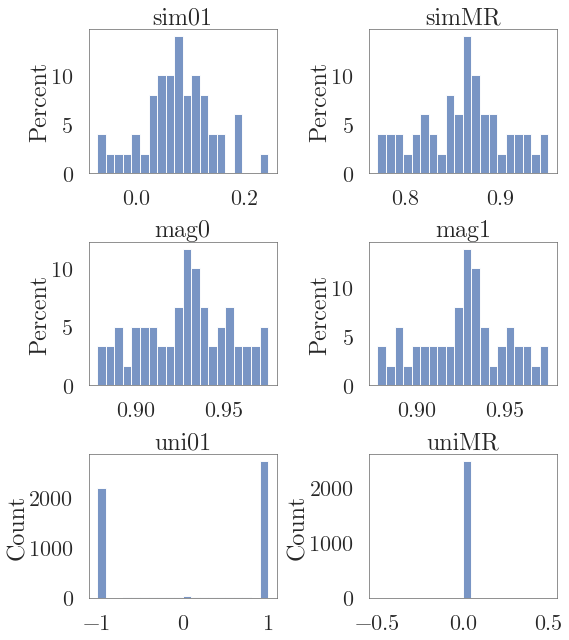

In [5]:
test_NQstates(5000, None, 0.1, 100, 10, T=0.1, tR=0.01,
    memory_mode="direct", cleanup_mode=None)

network 0
network 1
network 2
network 3
network 4
network 5
network 6
network 7
network 8
network 9


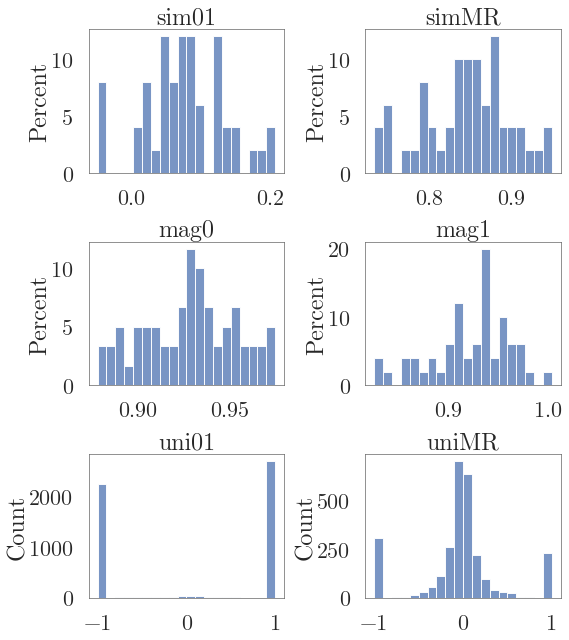

In [6]:
test_NQstates(5000, 500, 0.1, 100, 10, T=0.1, tR=0.01,
    memory_mode="array-radius", cleanup_mode=None)

network 0
network 1
network 2
network 3
network 4
network 5
network 6
network 7
network 8
network 9


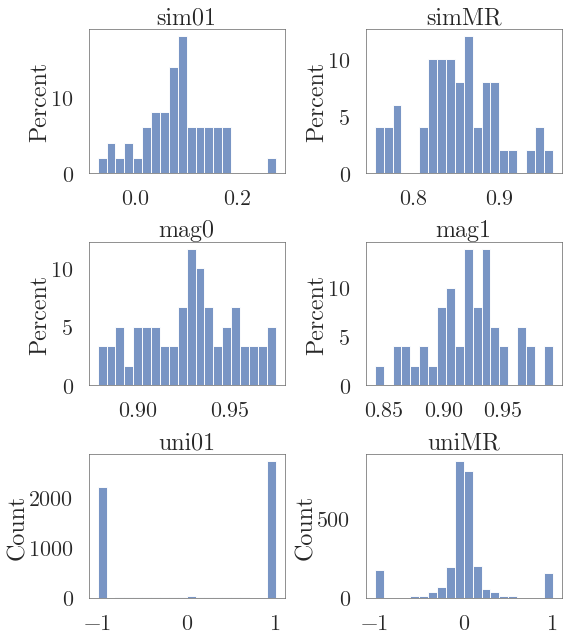

In [7]:
test_NQstates(5000, 2000, 0.1, 100, 10, T=0.1, tR=0.01,
    memory_mode="array-radius", cleanup_mode=None)

network 0
network 1
network 2
network 3
network 4
network 5
network 6
network 7
network 8
network 9


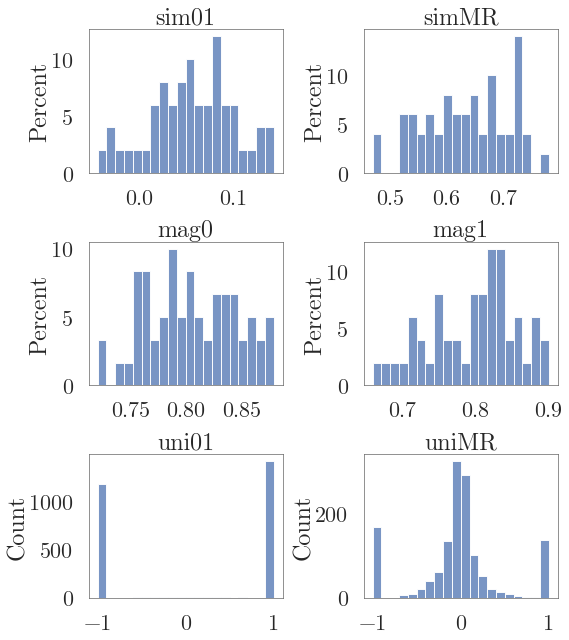

In [8]:
test_NQstates(5000, 500, 0.05, 100, 10, T=0.1, tR=0.01,
    memory_mode="array-radius", cleanup_mode=None)

network 0
network 1
network 2
network 3
network 4
network 5
network 6
network 7
network 8
network 9


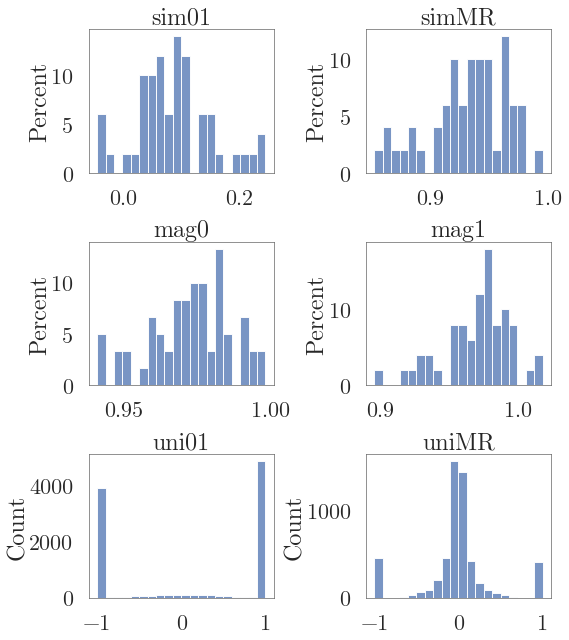

In [9]:
test_NQstates(5000, 500, 0.2, 100, 10, T=0.1, tR=0.01,
    memory_mode="array-radius", cleanup_mode=None)

network 0
network 1
network 2
network 3
network 4
network 5
network 6
network 7
network 8
network 9


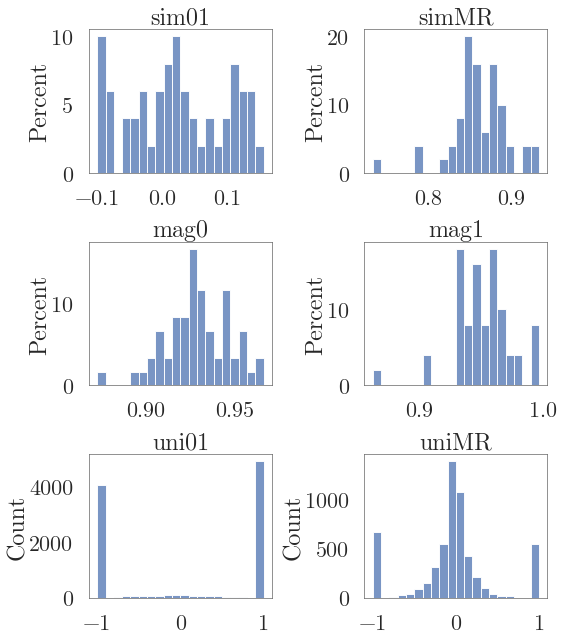

In [10]:
test_NQstates(5000, 500, 0.2, 200, 10, T=0.1, tR=0.01,
    memory_mode="array-radius", cleanup_mode=None)